In [1]:
using TaylorIntegration, TaylorSeries
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false)
const λ = 1.0
const Z = 2.0
const order = 30
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500000

500000

In [2]:
#Regularización KS
f(x, y) = [x^2 - y^2, 2x*y]
f(v) = f(v...)

f (generic function with 2 methods)

In [3]:
#Ecuaciones de movimiento 1D
function undrivenHelium1D!(τ, q, dq)
    Q₁, Q₂, P₁, P₂ = q
    
    t1 = Q₁^2
    t2 = Q₂^2
    t = t1 * t2
    R12 = t1 - t2
    aR12 = abs(R12)
    RRR = aR12^3
    c1 = R12/RRR
    c2 = 1 + 1/aR12
    #@show c2
    dq[1] = 0.25*t2*P₁
    dq[3] = 2*Q₁*(-0.125*P₂^2 + Z  - t2*c2  + t*c1)
    dq[2] = 0.25*t1*P₂
    dq[4] = 2*Q₂*(-0.125*P₁^2 + Z  - t1*c2 - t*c1)

#    return [t, q₁, q₂, p₁, p₂] 
    nothing
end

undrivenHelium1D! (generic function with 1 method)

In [4]:
function undrivenHelium2D!{T<:Number}(τ::T, q::Array{T,1}, dq::Array{T,1})
    Q₁x, Q₁y, Q₂x, Q₂y, P₁x, P₁y, P₂x, P₂y = q
    
    #Cantidades auxiliares
    Q₁² = Q₁x^2 + Q₁y^2
    Q₂² = Q₂x^2 + Q₂y^2
    P₁² = P₁x^2 + P₁y^2
    P₂² = P₂x^2 + P₂y^2
    t = Q₁²*Q₂²
    rf = f(Q₁x, Q₁y) - f(Q₂x, Q₂y)
    f₁, f₂ = rf
    fs = f₁^2 + f₂^2
    nf = sqrt(fs)
    c1 = 1 + 1/nf
    nf³ = nf^3
    factor1 = t/nf³
    s1 = -0.125P₂² + Z - Q₂²*c1
    s2 = factor1*f₁
    s3 = -0.125P₁² + Z - Q₁²*c1
    #@show c1
    dq[1], dq[2] = 0.25*Q₂²*[P₁x, P₁y]
    dq[3], dq[4] = 0.25*Q₁²*[P₂x, P₂y]
    dq[5] = 2*Q₁x*(s1 + s2) + factor1*f₂*Q₁y
    dq[6] = 2*Q₁y*(s1 - s2) + factor1*f₂*Q₁x
    dq[7] = 2*Q₂x*(s3 - s2) - factor1*f₂*Q₂y
    dq[8] = 2*Q₂y*(s3 + s2) - factor1*f₂*Q₂x
    nothing
end


var1 = set_variables("q₁x q₁y q₂x q₂y p₁x p₁y p₂x p₂y", order = 1)

function condini1D{T<:Number}(x10::T, px10::T)
    @assert x10 != 0
    Q1 = sqrt(x10)
    Q2 = 0.0
    P1 = 2*px10*sqrt(x10)    
    P2 = sqrt(8Z)    
    return [Q1, Q2, P1, P2]
end


function condini2D{T<:Number}(q₁x::T, q₁y::T, p₁x::T, p₁y::T, P₂y::T)
    @assert (q₁x > 0 || q₁y > 0) && P₂y^2 <= 8Z
    Q₁x = sqrt(sqrt(4q₁x^2 + q₁y^2) + 2q₁x)/2
    Q₁y = q₁y/(2Q₁x)
    Q₂x = 0.0
    Q₂y = 0.0
    P₁x = 2(Q₁x*p₁x + Q₁y*p₁y)
    P₁y = 2(Q₁x*p₁y - Q₁y*p₁x)
    P₂x = sqrt(8Z - P₂y^2)
    return T[Q₁x, Q₁y, Q₂x, Q₂y, P₁x, P₁y, P₂x, P₂y]
end




function regHam(q₁x, q₁y, q₂x, q₂y, p₁x, p₁y, p₂x, p₂y)
    #Cantidades auxiliares
    Q₁² = q₁x^2 + q₁y^2
    Q₂² = q₂x^2 + q₂y^2
    P₁² = p₁x^2 + p₁y^2
    P₂² = p₂x^2 + p₂y^2
    t = Q₁²*Q₂²
    rf = f(q₁x, q₁y) - f(q₂x, q₂y)
    f₁, f₂ = rf
    nf = (f₁^2 + f₂^2)^(1/2)
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + t*(1.0 + 1.0/nf)
    return H
end


regHam(v) = regHam(v...)

regHam (generic function with 2 methods)

In [5]:
a1 =  condini1D(2.577, 0.0) + Float64[0, 2.5, 3.2,0]

4-element Array{Float64,1}:
 1.6053
 2.5   
 3.2   
 4.0   

In [6]:
a2 = condini2D(2.577, 0.0, 0.0, 0.0, 0.0) + Float64[0.0, 0, 2.5, 0.0, 3.2, 0.0, 0.0, 0.0]

8-element Array{Float64,1}:
 1.6053
 0.0   
 2.5   
 0.0   
 3.2   
 0.0   
 4.0   
 0.0   

In [7]:
b1, b2 = similar(a1), similar(a2)
undrivenHelium1D!(0.0, a1, b1)
undrivenHelium2D!(0.0, a2, b2)

In [8]:
b1

4-element Array{Float64,1}:
   5.0    
   2.577  
 -29.3625 
  -6.82374

In [9]:
b2

8-element Array{Float64,1}:
   5.0    
   0.0    
   2.577  
   0.0    
 -29.3625 
   0.0    
  -6.82374
  -0.0    

In [10]:
function errHam(N::Int)
    srand(487293456)
    J = vcat(  hcat(zeros(4,4), eye(4,4)), hcat(-eye(4,4), zeros(4,4))  )
    
    dnorm = zeros(N)
    
    for j in 1:N
        al = condini2D(rand(5)...)
        #al = rand(8)
        meq = similar(al)
        alt = al + var1
        ene = J*∇(regHam(alt))
        ene1 = Float64[ene[k].coeffs[1].coeffs[1] for k in 1:8]
        undrivenHelium2D!(0.0, al, meq)
        dnorm[j] = norm(meq - ene1)/eps()
    end
    return dnorm  
end


errHam (generic function with 1 method)

  1.547787 seconds (1.49 M allocations: 79.903 MiB, 2.33% gc time)



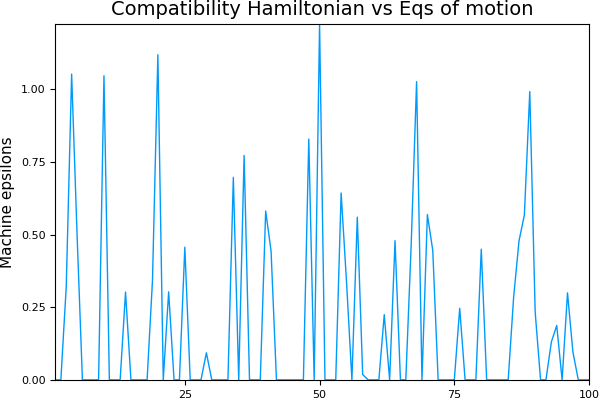

In [11]:
@time dnorm = errHam(100);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")
yaxis!("Machine epsilons")

In [12]:
#Esta es la condición inicial que se aproximó en 1D
c2 = condini2D(2.577, 0.0, 0.0, 0.0, 0.0)
c1 = condini1D(2.577,0.0)

4-element Array{Float64,1}:
 1.6053
 0.0   
 0.0   
 4.0   

## Hacemos el comparativo de los integradores en 1D y 2D

In [13]:
t2, x2 = taylorinteg(undrivenHelium2D!, c2, t0, 1.0, order, abs_tol, maxsteps=5)
@time t2, x2 = taylorinteg(undrivenHelium2D!, c2, t0, 100.0, order, abs_tol, maxsteps = 5_000);

  3.101183 seconds (32.21 M allocations: 3.298 GiB, 24.70% gc time)


Maximum number of integration steps reached; exiting.


In [14]:
t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 1.0, order, abs_tol, maxsteps=5)
@time t1, x1 = taylorinteg(undrivenHelium1D!, c1, t0, 100.0, order, abs_tol, maxsteps = 5_000);

  1.338778 seconds (14.66 M allocations: 1.512 GiB, 21.83% gc time)


In [15]:
function regHam(Q₁, Q₂, P₁, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nf = abs(Q₁² - Q₂²)
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + Q₁²*Q₂²*(1.0 + 1.0/nf)
    return H
end

regHam (generic function with 3 methods)

In [16]:
t1[end], t2[end]

(16.922700133915505, 16.922700133915068)

In [17]:
x1[end,:]

4-element Array{Float64,1}:
 45.6067 
  1.16784
 35.193  
  2.0694 

In [18]:
x2[end,:]

8-element Array{Float64,1}:
 45.6067 
  0.0    
  1.16784
  0.0    
 35.193  
  0.0    
  2.0694 
  0.0    

In [19]:
regHam(x1[end,:])

-2.9103830456733704e-11

In [20]:
regHam(x2[end,:])

-3.637978807091713e-12